In [34]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.util as model_util
import model.binary_models as binary_models
import model.train_binary_model as train_binary_model
import feature.util as feature_util
import feature.make_binary_dataset as make_binary_dataset
import plot.viz_sequence as viz_sequence
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import tqdm
tqdm.tqdm_notebook(range(1))

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


  0%|<bar/>| 0/1 [00:00<?, ?it/s]

### Define paths for the model and data of interest

In [19]:
# Shared paths/constants
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
input_length = 1000

In [5]:
files_spec_path = "/users/amtseng/att_priors/data/processed/ENCODE_TFChIP/binary/config/SPI1/SPI1_training_paths.json"
num_tasks = 4
model_class = binary_models.BinaryPredictor

In [67]:
# Extract the file specs
with open(files_spec_path, "r") as f:
    files_spec = json.load(f)
labels_hdf5 = files_spec["labels_hdf5"]
bin_labels_npy = files_spec["bin_labels_npy"]

In [7]:
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [12]:
# Import the model without priors
noprior_model_path = "/users/amtseng/att_priors/models/trained_models/binary_models/SPI1/1/model_ckpt_epoch_2.pt"
noprior_model = model_util.restore_model(model_class, noprior_model_path)
noprior_model.eval()
noprior_model = noprior_model.to(device)

In [13]:
# Import the model with priors
prior_model_path = "/users/amtseng/att_priors/models/trained_models/binary_models/SPI1_prior/1/model_ckpt_epoch_9.pt"
prior_model = model_util.restore_model(model_class, prior_model_path)
prior_model.eval()
prior_model = prior_model.to(device)

### Data preparation
Use classes from `make_profile_dataset` to prepare positive and negative inputs.

In [68]:
# Maps coordinates to 1-hot encoded sequence
coords_to_seq = feature_util.CoordsToSeq(reference_fasta, center_size_to_use=input_length)

# Maps bin index to profiles
bins_to_vals = make_binary_dataset.BinsToVals(labels_hdf5)

# Maps many bin indices to coordinates, inputs sequences, and output values for the network
def bin_inds_to_network_inputs(bin_inds):
    coords, outout_vals = bins_to_vals(bin_inds) 
    input_seqs = coords_to_seq(coords)
    return coords, input_seqs, outout_vals

In [69]:
# Import set of all labels
labels_array = np.load(bin_labels_npy, allow_pickle=True)

# Get set of positive and negative bin indices
pos_bin_inds = np.where(labels_array[:, 1] == 1)[0]
neg_bin_inds = np.where(labels_array[:, 1] == 0)[0]

### Predicting and plotting profiles

In [24]:
def predict_bin_inds(
    model, bin_inds, fourier_att_prior_freq_limit=160,
    fourier_att_prior_freq_limit_softness=None, print_losses=True
):
    """
    Fetches the necessary data from the given bin indices and runs it through the
    network. Returns the coordinates, network predictions, the true values from
    the dataset, the input gradients, and the loss values. The returned values
    are post-sigmoid probabilities. Returned values are all NumPy arrays.
    """
    coords, input_seqs_np, output_vals_np = bin_inds_to_network_inputs(bin_inds)
    
    input_seqs = model_util.place_tensor(torch.tensor(input_seqs_np)).float()
    output_vals = model_util.place_tensor(torch.tensor(output_vals_np)).float()

    model.zero_grad()
    
    # Run through the model
    input_seqs.requires_grad = True  # Set gradient required
    logit_pred_vals = model(input_seqs)
    
    # Compute input gradients
    input_grads, = torch.autograd.grad(
        logit_pred_vals, input_seqs,
        grad_outputs=model_util.place_tensor(torch.ones(logit_pred_vals.size())),
        retain_graph=True, create_graph=True
    )
    input_grads_np = input_grads.detach().cpu().numpy()
    
    input_grads = input_grads * input_seqs
    
    status = model_util.place_tensor(torch.ones(output_vals_np.shape[0]))
    loss, (corr_loss, att_loss) = \
        train_binary_model.model_loss(
            model, output_vals, logit_pred_vals, 0, True, 20,
            None, 1, 3, fourier_att_prior_freq_limit,
            fourier_att_prior_freq_limit_softness, False, input_grads, status
    )
    corr_loss, att_loss = corr_loss.item(), att_loss.item()
    if print_losses:
        print("Correctness loss\tPrior loss")
        print("%6.3f\t%6.3f" % (corr_loss, att_loss))
    
    # Convert logit profile predictions to probabilities
    pred_vals = binary_models.binary_logits_to_probs(logit_pred_vals)
    
    return coords, pred_vals.detach().cpu().numpy(), output_vals_np, \
        input_seqs_np, input_grads_np, corr_loss, att_loss

### Computing/plotting Fourier transforms

In [16]:
def dft(signal):
    fourier_coeffs = np.fft.fft(signal)
    fourier_freqs = 2 * np.pi * np.fft.fftfreq(signal.size)
    fourier_freqs = fourier_freqs[:int(len(fourier_freqs) / 2)]  # Only the positive frequencies
    mags = np.abs(fourier_coeffs)[:int(len(fourier_coeffs) / 2)]  # Frequency magnitudes are symmetric
    return fourier_freqs, mags

In [17]:
def plot_grad_and_fft(input_grad, input_seq, include_dc=False, pos_limit=None):
    assert len(input_grad.shape) == 2
    assert len(input_seq.shape) == 2
    
    grad_x_seq = np.sum(input_grad * input_seq, axis=1)
    abs_grad = np.abs(grad_x_seq)
    freqs, mags = dft(abs_grad)
    
    if not include_dc:
        freqs, mags = freqs[1:], mags[1:]
    
    # Plot the original signal, absolute value, and the DFT
    fig, ax = plt.subplots(3, 1, figsize=(20, 10))
    ax[0].plot(grad_x_seq)
    ax[0].set_title("Input gradient * input sequence")
    ax[0].margins(0)
    ax[1].plot(abs_grad)
    ax[1].set_title("|Input gradient * input sequence|")
    ax[1].margins(0)
    ax[2].plot(freqs, mags, color="red")
    ax[2].set_xlabel("Frequency (radians)")
    ax[2].set_ylabel("|Frequency component|")
    if pos_limit is not None:
        pos_limit_radians = pos_limit * 2 * np.pi / len(grad_x_seq)
        ax[2].axvline(x=pos_limit_radians, color="black")
    ax[2].margins(0)
    fig.tight_layout()

### Compare the performance between the two conditions

In [43]:
# Draw a sample of bin indices, and compute the correctness loss and attribution prior loss
# of each bin index for both models
bin_inds = []
noprior_corr_loss_values, noprior_att_loss_values = [], []
prior_corr_loss_values, prior_att_loss_values = [], []

# Sample from chr8 and chr10
sample = np.concatenate([
    np.random.choice(pos_bin_inds, size=500, replace=False),
    np.random.choice(neg_bin_inds, size=500, replace=False)
])

for bin_ind in tqdm.notebook.tqdm(sample):
    _, _, _, _, _, corr_loss, att_loss = predict_bin_inds(
        noprior_model, [bin_ind], print_losses=False
    )
    noprior_corr_loss_values.append(corr_loss)
    noprior_att_loss_values.append(att_loss)
    
    _, _, _, _, _, corr_loss, att_loss = predict_bin_inds(
        prior_model, [bin_ind], print_losses=False
    )
    prior_corr_loss_values.append(corr_loss)
    prior_att_loss_values.append(att_loss)

    bin_inds.append(bin_ind)

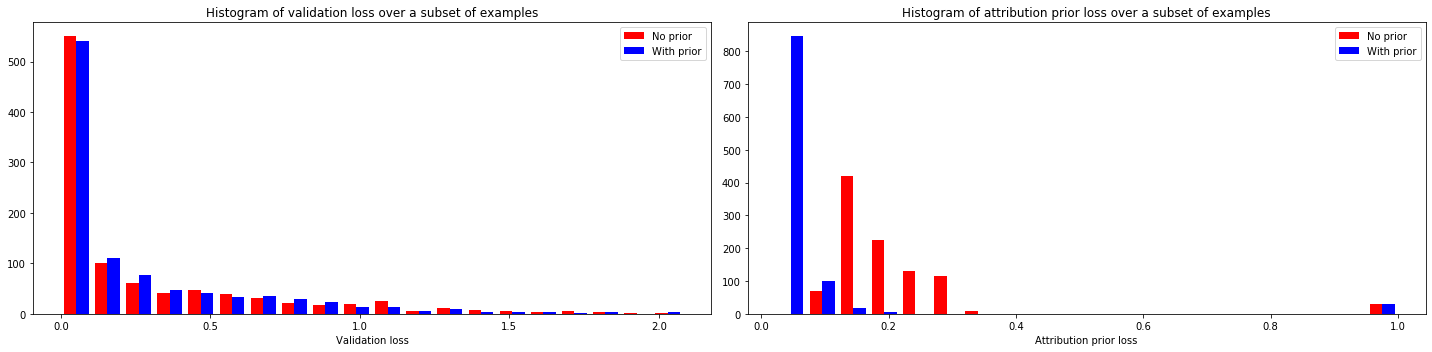

In [44]:
# Plot histogram of these values over both conditions
bin_num = 20
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].hist(
    [noprior_corr_loss_values, prior_corr_loss_values],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"])
ax[0].set_title("Histogram of validation loss over a subset of examples")
ax[0].set_xlabel("Validation loss")
ax[0].legend()
ax[1].hist(
    [noprior_att_loss_values, prior_att_loss_values],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"])
ax[1].set_title("Histogram of attribution prior loss over a subset of examples")
ax[1].set_xlabel("Attribution prior loss")
ax[1].legend()
plt.tight_layout()

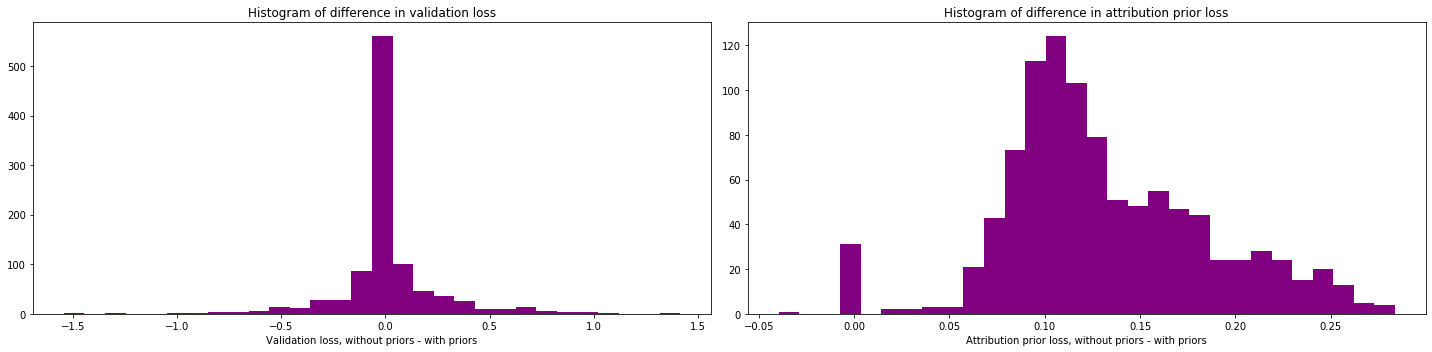

In [46]:
# Plot histogram of values DIFFERENCE over both conditions
corr_loss_diffs = np.array(noprior_corr_loss_values) - np.array(prior_corr_loss_values)
att_loss_diffs = np.array(noprior_att_loss_values) - np.array(prior_att_loss_values)
bin_num = 30

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].hist(corr_loss_diffs, bin_num, histtype="bar", color="purple")
ax[0].set_title("Histogram of difference in validation loss")
ax[0].set_xlabel("Validation loss, without priors - with priors")
ax[1].hist(att_loss_diffs, bin_num, histtype="bar", color="purple")
ax[1].set_title("Histogram of difference in attribution prior loss")
ax[1].set_xlabel("Attribution prior loss, without priors - with priors")
plt.tight_layout()

### View predictions

In [52]:
def predict_and_plot(model, bin_ind, seq_slice=slice(650, 750)):
    coords, pred_vals, true_vals, input_seqs, input_grads, \
        corr_loss, att_loss = predict_bin_inds(model, [bin_ind])

    plot_grad_and_fft(input_grads[0], input_seqs[0], pos_limit=200)
    viz_sequence.plot_weights(input_grads[0][seq_slice])
    viz_sequence.plot_weights((input_grads[0] * input_seqs[0])[seq_slice])

Correctness loss	Prior loss
 0.638	 0.130


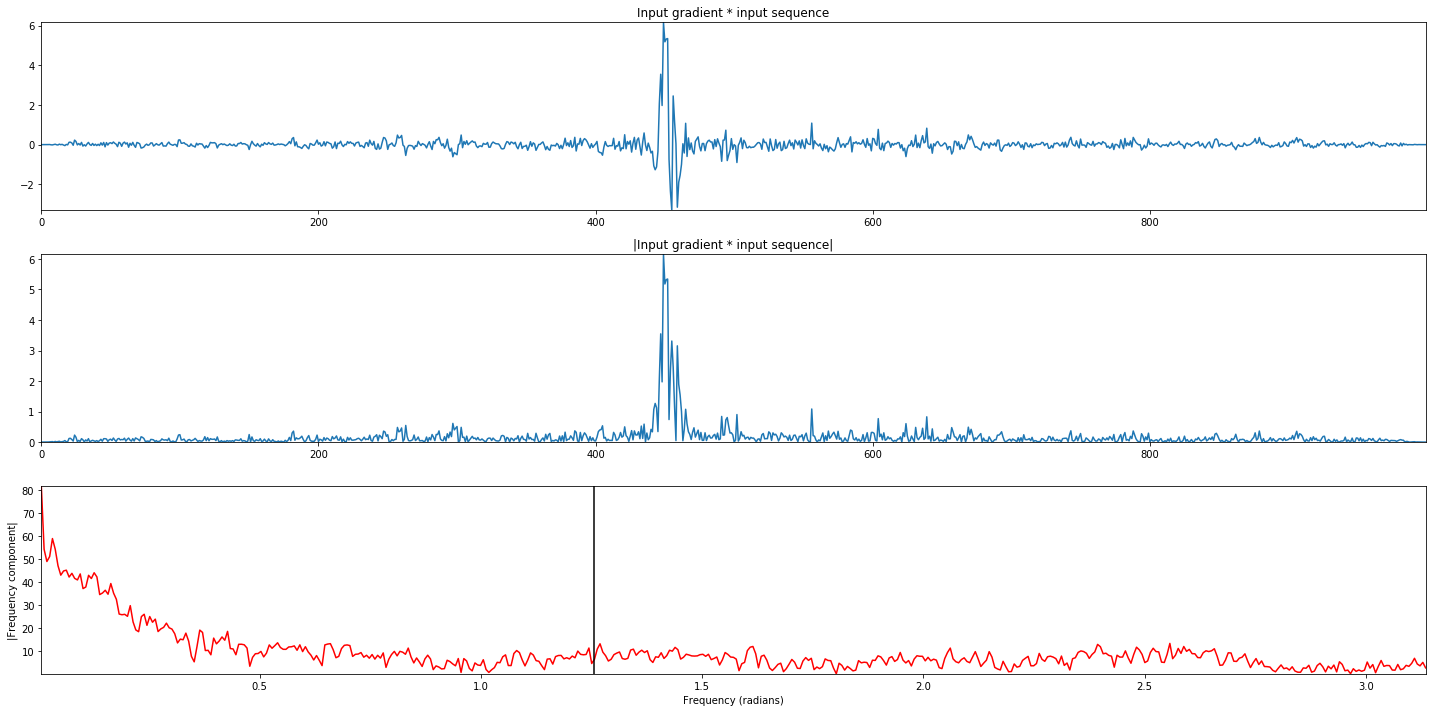

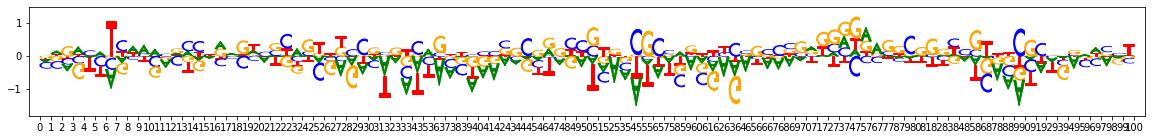

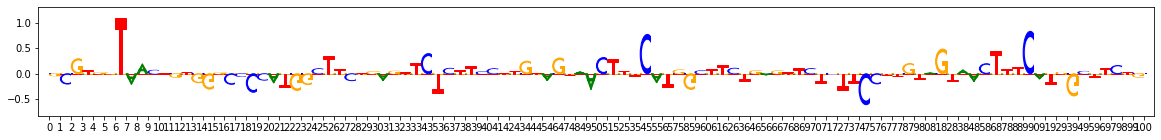

Correctness loss	Prior loss
 0.429	 0.033


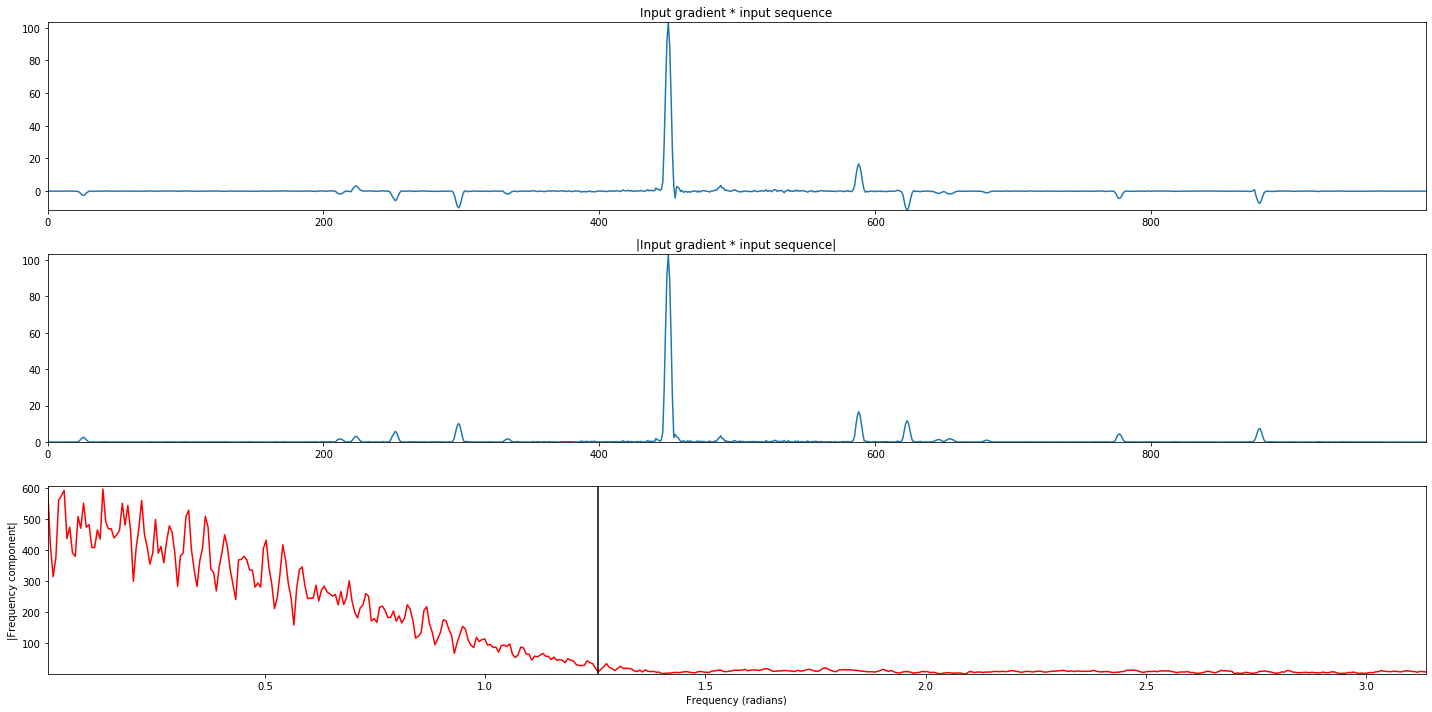

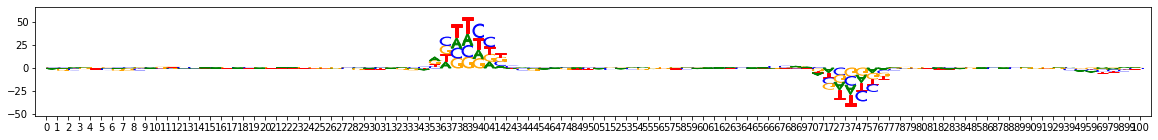

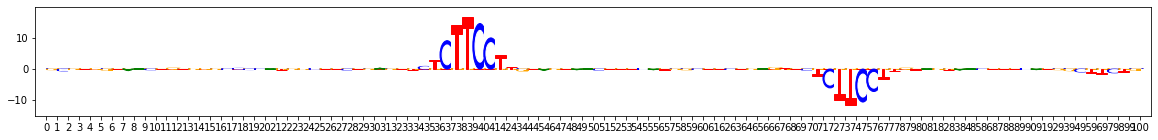

In [73]:
bin_ind = pos_bin_inds[395]
seq_slice = slice(550, 650)
predict_and_plot(noprior_model, bin_ind, seq_slice)
predict_and_plot(prior_model, bin_ind, seq_slice)